In [48]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# import needed libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Loading dataset and splitting to validation and training

In [2]:
DATA_DIR = '/kaggle/input/validaion-if-a-real-posm/dataset_for_img_validation/' # dir with dataset imgs

CLASSES = [
    'good',
    'trash'
]

NUM_CLASSES = len(CLASSES)

IMAGE_RESIZE = 224
img_size = IMAGE_RESIZE
OBJECTIVE_FUNCTION = 'binary_crossentropy'
LOSS_METRICS = ['recall']

NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 79
STEPS_PER_EPOCH_VALIDATION = 20
BATCH_SIZE_TRAINING = 54
BATCH_SIZE_VALIDATION = 16

In [3]:
# Uploading imgs and add some augmentation
X, y = [], []
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range= 20,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(DATA_DIR, target_size=(img_size, img_size), batch_size=BATCH_SIZE_TRAINING, subset='training', shuffle=True)

validation_generator = train_datagen.flow_from_directory(DATA_DIR, target_size=(img_size, img_size), batch_size=BATCH_SIZE_VALIDATION, subset='validation', shuffle=True)

Found 1251 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


In [4]:
X, y = next(train_generator)

In [5]:
print(X.shape)
print(y.shape)

(54, 224, 224, 3)
(54, 2)


In [6]:
print("Classes as index:", train_generator.class_indices)

Classes as index: {'good': 0, 'trash': 1}


# Creating and compiling the model

In [17]:
base_model = tf.keras.applications.ResNet101(weights = 'imagenet', include_top = False)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
# take base model convolution layers from resnet
x = base_model.output
# compress incoming feature maps from resnet layers
x = GlobalAveragePooling2D()(x)
# and add fresh top of dense layers
# each node will distinguish between 1024 or 512 features
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = tf.keras.layers.Dense(2, activation = 'softmax')(x)
# create new model from both components
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model.summary()

In [19]:
# lock all resnet layers 1-174
for layer in model.layers[:175]:
    layer.trainable = False
# the new dense layers have to be trainable
for layer in model.layers[175:]:
    layer.trainable = True

In [20]:
adam_optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["recall"])


In [21]:
fit_history1 = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs = NUM_EPOCHS,
    validation_data=validation_generator, #not correct pass of val_dataset, led to error with calcutation of validation params
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
)

Epoch 1/10


W0000 00:00:1715927397.699131     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/79 ━━━━━━━━━━━━━━━━━━━━ 34:54 27s/step - loss: 5.2104 - recall: 0.5132  

W0000 00:00:1715927425.278463     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/79 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - loss: 6.3576 - recall: 0.5018

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1715927456.053062     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 157s 900ms/step - loss: 3.9385 - recall: 0.5069 - val_loss: 1867010601260154880.0000 - val_recall: 0.4855
Epoch 2/10


W0000 00:00:1715927468.333039     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - loss: 0.6854 - recall: 0.5628 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 327ms/step - loss: 0.6702 - recall: 0.6020 - val_loss: 885436.0000 - val_recall: 0.4855
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 245ms/step - loss: 0.6766 - recall: 0.5630 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 321ms/step - loss: 0.6737 - recall: 0.6023 - val_loss: 1033.8168 - val_recall: 0.4855
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - loss: 0.6771 - recall: 0.5663 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 336ms/step - loss: 0.6820 - recall: 0.5670 - val_loss: 45.9454 - val_recall: 0.4791
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 238ms/step - loss: 0.6717 - recall: 0.5857 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - loss: 0.6795 - recall: 0.5756 - val_loss

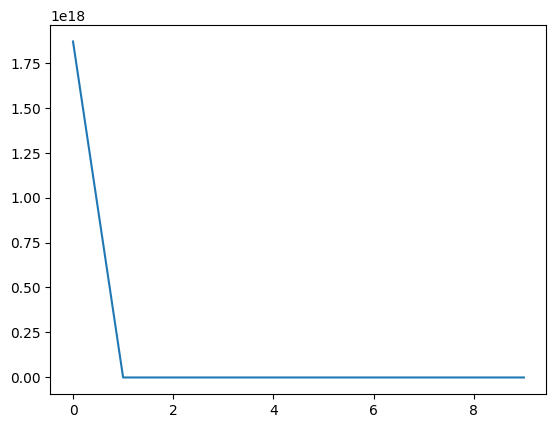

In [27]:
plt.plot(fit_history1.history['loss'])

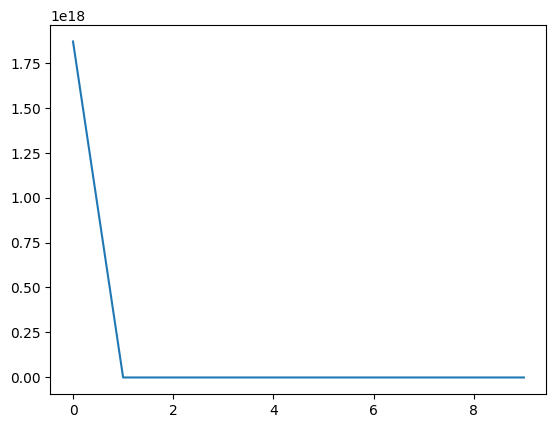

In [28]:
plt.plot(fit_history1.history['val_loss'])

Validation generator wasn't passed to a model in a correct way, this led to strange counting of val_loss and val_recll. Model is still converging, and this mistake will be fixed a bit later.

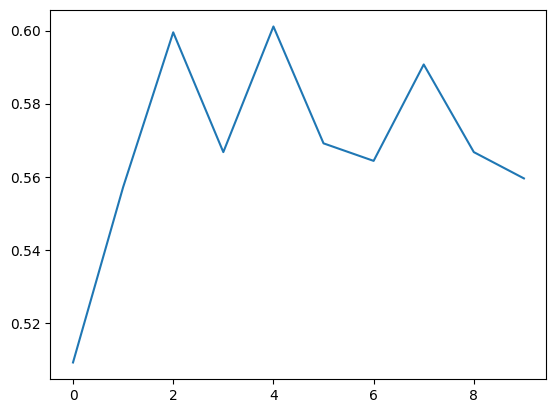

In [29]:
plt.plot(fit_history1.history['recall'])

In [30]:
# lock all resnet layers 1-174
for layer in model.layers:
    layer.trainable = True

In [31]:
adam_optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["recall"])

In [32]:
fit_history2 = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs = 20,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
)

Epoch 1/20


W0000 00:00:1715927961.668942     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/79 ━━━━━━━━━━━━━━━━━━━━ 31:02 25s/step - loss: 0.9583 - recall: 0.5192 

W0000 00:00:1715928011.280939     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/79 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - loss: 0.8528 - recall: 0.5238

W0000 00:00:1715928038.633934     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 0.8022 - recall: 0.5270 - val_loss: 3647163705118721944059904.0000 - val_recall: 0.4855
Epoch 2/20


W0000 00:00:1715928047.972637     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - loss: 0.5884 - recall: 0.7170 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 351ms/step - loss: 0.5299 - recall: 0.7555 - val_loss: 634652.5000 - val_recall: 0.4855
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - loss: 0.4488 - recall: 0.8113 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 363ms/step - loss: 0.3987 - recall: 0.8342 - val_loss: 48028.3906 - val_recall: 0.4855
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - loss: 0.4402 - recall: 0.7912 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - loss: 0.4802 - recall: 0.8171 - val_loss: 21332.0723 - val_recall: 0.4855
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - loss: 0.4452 - recall: 0.8202 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - loss: 0.4168 - recall: 0.8316 - val_

# Check

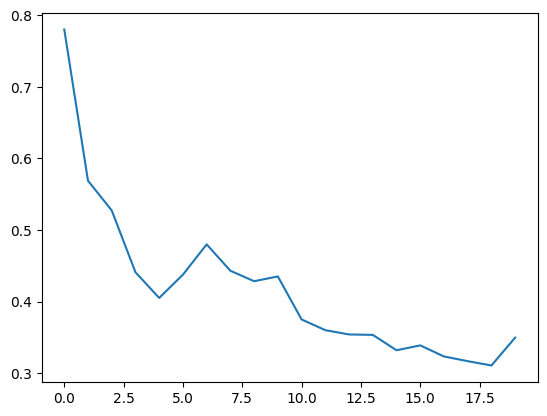

In [37]:
plt.plot(fit_history2.history['loss'])

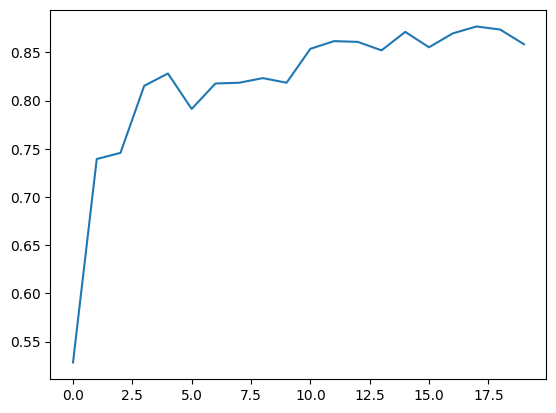

In [36]:
plt.plot(fit_history2.history['recall'])

In [45]:
res_prediction = model.predict(X[1:3])

Exception ignored in: <function _xla_gc_callback at 0x7962729b9090>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step


W0000 00:00:1715929212.932607     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.053417  , 0.946583  ],
       [0.85857683, 0.14142317]], dtype=float32)

# Export

In [38]:
model.save('/kaggle/working/model_best_recall.keras') 

In [50]:
pred_model = keras.models.load_model('/kaggle/working/model_best_recall.keras')


In [63]:
pred_model.predict( X[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.05341705, 0.946583  ]], dtype=float32)

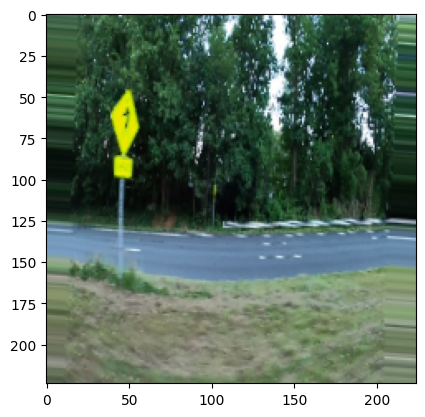

In [65]:
plt.imshow(X[1])

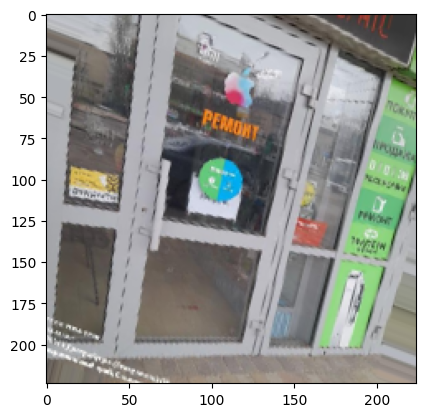

In [66]:
plt.imshow(X[2])